# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [4]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [5]:
feat_info.head(40)

attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]
20         LP_STATUS_GROB            person  categorical                [0]
21       NATIONALITAET_KZ            person  categorical             [-1,0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
23         RETOURTYP_BK_S            person      ordinal                [0]
24              SEMIO_SOZ            person      ordinal             [-1,9]
25              SEMIO_FAM            person      ordinal             [-1,9]
26              SEMIO_REL            person      ordinal             [-1,9]
27              SEMIO_MAT            person      ordinal             [-1,9]
28             SEMIO_VERT            person      ordinal             [-1,9]
29             SEMIO_LUST            person      ordinal             [-1,9]
30              SEMIO_ERL            person      ordinal             [-1,9]
31             SEMIO_KULT            person      ordinal             [-1,9]
32              SEMIO_RAT            person      ordinal             [-1,9]
33             SEMIO_KRIT            person      ordinal             [-1,9]
34              SEMIO_DOM            person      ordinal             [-1,9]
35             SEMIO_KAEM            person      ordinal             [-1,9]
36          SEMIO_PFLICHT            person      ordinal             [-1,9]
37            SEMIO_TRADV            person      ordinal             [-1,9]
38            SHOPPER_TYP            person  categorical               [-1]
39                SOHO_KZ            person  categorical               [-1]

In [6]:
feat_info.describe()


attribute information_level     type missing_or_unknown
count                      85                85       85                 85
unique                     85                 9        5                  9
top     PRAEGENDE_JUGENDJAHRE            person  ordinal               [-1]
freq                        1                43       49                 26

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
print (azdias.isnull().sum().sum())

4896838


In [8]:
def parse(input):
    retval = input.strip('[]').split(',')
    return retval

def transform_column(column_name, miss_values):
    
    if column_name not in azdias.columns:
        print(column_name + ' not in azdias dataframe')
        return
    
    if len(miss_values) == 0:
        return

    if (miss_values == ['']):
        print(column_name + ' is invalid')
        return

    refined_missing_values =[]
    try:
        if(azdias[column_name].dtype == np.float64 ):
            for each in miss_values:
                refined_missing_values.append(float(each))
        elif (azdias[column_name].dtype == np.int64):
            for each in miss_values:
                refined_missing_values.append(int(each))
        else:
            for each in miss_values:
                refined_missing_values.append(each)
    except ValueError:
        print("Value Error:", column_name, each)
        print(azdias[column_name].dtype)

    for each in refined_missing_values:
        azdias[column_name] = azdias[column_name].replace(each, np.nan)
        
for index, row in feat_info.iterrows():
    miss_values = parse(row['missing_or_unknown'])
    column_name = row['attribute']
    transform_column(column_name, miss_values)
    

GFK_URLAUBERTYP is invalid
GREEN_AVANTGARDE is invalid
ANZ_PERSONEN is invalid
ANZ_TITEL is invalid
ANZ_HH_TITEL is invalid
KONSUMNAEHE is invalid
GEBAEUDETYP_RASTER is invalid
MOBI_REGIO is invalid
ONLINE_AFFINITAET is invalid
KBA13_ANZAHL_PKW is invalid


In [9]:
azdias.head(10)

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   
5       3.0                   1.0          2            2.0   
6       NaN                   2.0          2            5.0   
7       NaN                   1.0          1            3.0   
8       NaN                   3.0          1            3.0   
9       NaN                   3.0          2            4.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   
5                  3              1                 5               2   
6                  1              5                 1               5   
7                  3              3                 4               1   
8                  4              4                 2               4   
9                  2              4                 2               3   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   
5                      2                 5    ...            2.0         3.0   
6                      4                 3    ...            3.0         3.0   
7                      3                 2    ...            3.0         3.0   
8                      2                 2    ...            2.0         3.0   
9                      5                 4    ...            2.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   
5         1.0         1.0          1.0       5.0       5.0     2.0   
6         1.0         0.0          1.0       5.0       5.0     4.0   
7         1.0         0.0          1.0       4.0       4.0     2.0   
8         2.0         1.0          1.0       3.0       3.0     2.0   
9         2.0         1.0          1.0       3.0       3.0     2.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  
5          3.0       3.0  
6          6.0       3.0  
7          5.0       2.0  
8          4.0       3.0  
9          3.0       1.0  

[10 rows x 85 columns]

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
print(azdias.isnull().sum())



AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

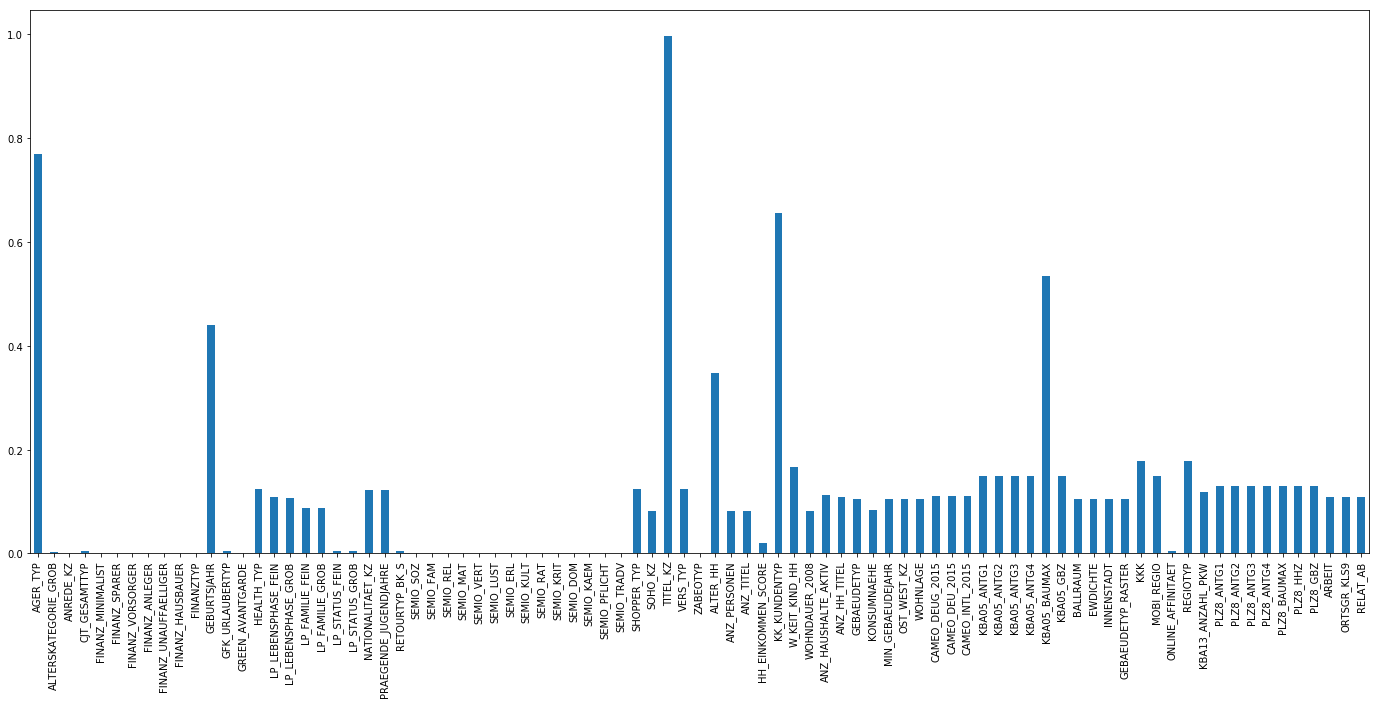

In [11]:
# Investigate patterns in the amount of missing data in each column.
(azdias.isnull().sum() / len(azdias)).plot(kind='bar', figsize=(24, 10))

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

'''
According to the histgram above, 
we found that few columns that got more than 60% missing data, 
which are the targets to be removed

AGER_TYP, TITEL_KZ, KK_KUNDENTYP, KBA05_BAUMAX
'''

azdias.drop(['AGER_TYP', 'TITEL_KZ','KK_KUNDENTYP', 'KBA05_BAUMAX'], axis=1, inplace=True)


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [13]:
# How much data is missing in each row of the dataset?
azdias.isnull()

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                      False      False          False              False   
1                      False      False          False              False   
2                      False      False          False              False   
3                      False      False          False              False   
4                      False      False          False              False   
5                      False      False          False              False   
6                      False      False          False              False   
7                      False      False          False              False   
8                      False      False          False              False   
9                      False      False          False              False   
10                     False      False          False              False   
11                     False      False          False              False   
12                     False      False          False              False   
13                     False      False          False              False   
14                     False      False          False              False   
15                     False      False          False              False   
16                     False      False          False              False   
17                     False      False          False              False   
18                     False      False          False              False   
19                     False      False          False              False   
20                     False      False          False              False   
21                     False      False          False              False   
22                     False      False          False              False   
23                     False      False          False              False   
24                     False      False          False              False   
25                     False      False          False              False   
26                     False      False          False              False   
27                     False      False          False              False   
28                     False      False          False              False   
29                     False      False          False              False   
...                      ...        ...            ...                ...   
891191                 False      False          False              False   
891192                 False      False          False              False   
891193                 False      False          False              False   
891194                 False      False          False              False   
891195                 False      False          False              False   
891196                 False      False          False              False   
891197                 False      False          False              False   
891198                 False      False          False              False   
891199                 False      False          False              False   
891200                 False      False          False              False   
891201                 False      False          False              False   
891202                 False      False          False              False   
891203                 False      False          False              False   
891204                 False      False          False              False   
891205                 False      False          False              False   
891206                 False      False          False              False   
891207                 False      False          False              False   
891208                 False      False          False              False   
891209                 False      False          False              False   
891210                 False      False          False              False   
8912

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
num_of_missing_column = 10

subset_above = azdias.dropna(thresh=azdias.shape[1]-num_of_missing_column)
print(len(subset_above))

subset_below = azdias[~azdias.index.isin(subset_above.index)]
print(len(subset_below))

776422
114799


In [15]:
subset_below.isnull().sum(axis=1)

0         45
11        49
14        49
17        49
20        12
24        49
26        21
30        36
35        45
46        42
48        49
53        45
54        49
61        45
62        45
69        49
75        49
76        45
81        47
83        45
90        36
97        49
99        49
103       49
106       45
108       49
109       45
112       49
133       49
137       49
          ..
891049    49
891055    34
891061    45
891062    19
891063    45
891064    49
891069    17
891072    49
891074    36
891092    49
891095    49
891100    35
891117    19
891119    19
891120    19
891130    34
891137    34
891140    34
891154    13
891159    45
891164    45
891169    20
891170    19
891171    36
891172    16
891173    20
891175    49
891185    49
891187    49
891203    16
Length: 114799, dtype: int64

In [16]:
subset_above['ZABEOTYP'].head(10)

1     5
2     5
3     3
4     4
5     4
6     4
7     1
8     6
9     4
10    3
Name: ZABEOTYP, dtype: int64

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


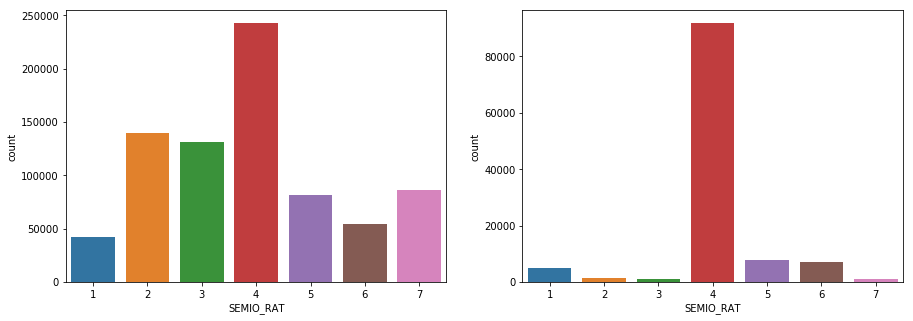

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# First of all, just listed the columns (file) with no missing or few missing values 
# [FINALZ_ANLEGER, ALTERSKATEGORIE_GROB, SEMIO_SOZ, SEMIO_RAT, ZABEOTYP]

def compare(column_name, df1=subset_above, df2=subset_below):
    fig, ax = plt.subplots(figsize=(15,5),nrows=1, ncols=2)
    sns.countplot(df1[column_name], ax=ax[0])
    sns.countplot(df2[column_name], ax=ax[1])
    fig.show()
    
columns = ['FINANZ_HAUSBAUER', 'ALTERSKATEGORIE_GROB', 'SEMIO_SOZ', 'SEMIO_RAT', 'ZABEOTYP']


for each in columns:
    compare(each)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

*Answer*：We could see that they all have different distributions and thus are qualitatively different.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# How many features are there of each data type?
FLOAT = 'float'
INT = 'int64'
OBJECT = 'object'

feature_count = {FLOAT:0, INT:0, OBJECT:0}

def getType(column_name):
    if column_name not in azdias.columns:
        return
    if(azdias[column_name].dtype == np.float64 ):
        feature_count[FLOAT] += 1
    elif (azdias[column_name].dtype == np.int64):
        feature_count[INT] += 1
    else:
        feature_count[OBJECT] += 1
                
for index, row in feat_info.iterrows():
    column_name = row['attribute']
    getType(column_name)
    
feature_count

{'float': 53, 'int64': 24, 'object': 4}

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
feat_info[feat_info['attribute'] == 'OST_WEST_KZ']

attribute information_level         type missing_or_unknown
55  OST_WEST_KZ          building  categorical               [-1]

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
from pandas.api.types import is_numeric_dtype

BINARY_NUM = 'BINARY_NUM'
BINARY_NOT_NUM = 'BINARY_NOT_NUM'
MULTI_LVL = 'MULTI_LVL'

categorical_features = {BINARY_NUM:[],
                       BINARY_NOT_NUM:[],
                       MULTI_LVL:[]}

def isBinary(data):
    return data.dropna().value_counts().index.size == 2

def getCategoricalFeatures():
    for index, row in feat_info.iterrows():
        _column_name = row['attribute']
        if _column_name not in azdias.columns:
            continue
        
        _type = row['type']
        _dtype = azdias[_column_name].dtype
        
        if not _type == 'categorical':
            continue
        
        _isBinary = isBinary(azdias[_column_name])

        if (_isBinary and is_numeric_dtype(azdias[_column_name])):
            categorical_features[BINARY_NUM].append(_column_name)
        elif (_isBinary):
            categorical_features[BINARY_NOT_NUM].append(_column_name)
        elif (not _isBinary):
            categorical_features[MULTI_LVL].append(_column_name)
        else:
            raise ValueError(_dtype, _column_name)

getCategoricalFeatures()
            
categorical_features

{'BINARY_NUM': ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP'],
 'BINARY_NOT_NUM': ['OST_WEST_KZ'],
 'MULTI_LVL': ['CJT_GESAMTTYP',
  'FINANZTYP',
  'GFK_URLAUBERTYP',
  'LP_FAMILIE_FEIN',
  'LP_FAMILIE_GROB',
  'LP_STATUS_FEIN',
  'LP_STATUS_GROB',
  'NATIONALITAET_KZ',
  'SHOPPER_TYP',
  'ZABEOTYP',
  'GEBAEUDETYP',
  'CAMEO_DEUG_2015',
  'CAMEO_DEU_2015']}

In [21]:
# Re-encode categorical variable(s) to be kept in the analysis.
# working_subset = subset_above.dropna(subset=categorical_features[BINARY_NO_NUM])
# working_subset = working_subset.dropna(subset=categorical_features[MULTI_LVL])

working_subset = subset_above.copy()

for column in categorical_features[BINARY_NOT_NUM]:
    # deal with string categorical 
    working_subset[column] = working_subset[column].apply(lambda x: 0 if x == 'o' else 1)

for column in categorical_features[MULTI_LVL]:
    working_subset = working_subset.drop(column,axis = 1)
    

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

*answer*: 
1. By checking the data type of features we got follow data: {'float': 53, 'int64': 24, 'object': 4}, meaning 53 features using float data type, 24 features in integer type and 4 features in object type.

2. Also analyzed the categorical features, and found that the binary feature SOHO_KZ is in float data type, I changed this to integer but doubt if it is necessary. Additionaly, there are 16 categorical features having multiple results, to keep it simple, we drop all of them.

3. Finally we got 65 features after refined.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [22]:
feat_info[feat_info['attribute'] == 'KBA05_BAUMAX']

attribute information_level   type missing_or_unknown
64  KBA05_BAUMAX     microcell_rr3  mixed             [-1,0]

In [23]:
feat_info[feat_info['type'] == 'mixed']

attribute information_level   type missing_or_unknown
15    LP_LEBENSPHASE_FEIN            person  mixed                [0]
16    LP_LEBENSPHASE_GROB            person  mixed                [0]
22  PRAEGENDE_JUGENDJAHRE            person  mixed             [-1,0]
56               WOHNLAGE          building  mixed               [-1]
59        CAMEO_INTL_2015     microcell_rr4  mixed            [-1,XX]
64           KBA05_BAUMAX     microcell_rr3  mixed             [-1,0]
79            PLZ8_BAUMAX    macrocell_plz8  mixed             [-1,0]

In [24]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# subset_above['PRAEGENDE_JUGENDJAHRE'] = subset_above['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: int(x) if x != np.nan else np.nan)

def processMixedColumns(df):
    '''
    -  1: 40s - war years (Mainstream, E+W)
    -  2: 40s - reconstruction years (Avantgarde, E+W)
    -  3: 50s - economic miracle (Mainstream, E+W)
    -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
    -  5: 60s - economic miracle (Mainstream, E+W)
    -  6: 60s - generation 68 / student protestors (Avantgarde, W)
    -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
    -  8: 70s - family orientation (Mainstream, E+W)
    -  9: 70s - peace movement (Avantgarde, E+W)
    - 10: 80s - Generation Golf (Mainstream, W)
    - 11: 80s - ecological awareness (Avantgarde, W)
    - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
    - 13: 80s - Swords into ploughshares (Avantgarde, E)
    - 14: 90s - digital media kids (Mainstream, E+W)
    - 15: 90s - ecological awareness (Avantgarde, E+W)
    '''  
    decade_map = {
        1:40, 2: 40,  
        3:50, 4:50, 
        5:60, 6:60, 7:60, 
        8:70, 9:70, 
        10:80, 11:80, 12:80, 13:80,
        14:90, 15:90
    }

    MAINSTREAM = 0
    AVANTGARDE = 1

    movement_map ={
        1: MAINSTREAM, 2: AVANTGARDE, 3: MAINSTREAM, 4: AVANTGARDE, 5: MAINSTREAM, 6: AVANTGARDE,
        7: AVANTGARDE, 8: MAINSTREAM, 9: AVANTGARDE, 10: MAINSTREAM, 11: AVANTGARDE, 12: MAINSTREAM,
        13: AVANTGARDE, 14: MAINSTREAM, 15: AVANTGARDE
    }
    
    # PRAEGENDE_JUGENDJAHRE 
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: decade_map[x] if not pd.isnull(x) else np.nan)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: movement_map[x] if not pd.isnull(x) else np.nan)
    
    # CAMEO_INTL_2015 
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x)/10 if not pd.isnull(x) else np.nan)
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x)%10 if not pd.isnull(x) else np.nan)
    
    df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
    df.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)
    df.drop(['LP_LEBENSPHASE_FEIN'], axis =1 , inplace=True)
    df.drop(['LP_LEBENSPHASE_GROB'], axis =1 , inplace=True)
    df.drop(['WOHNLAGE'], axis =1 , inplace=True)

processMixedColumns(working_subset)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

    *answer*: in this step, I did some data transformation on mixed data columns [PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015]. Added several new columns ['DECADE', 'MOVEMENT', 'WEALTH', 'LIFE_STAGE']. Also dropped the original columns PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015
    
    LP_LEBENSPHASE_FEIN is droped as it contains too mixed information: From 1-8 it contains mariage, income, and age. while 9,17,22,... doesn't contain any age information, nor income. Some number like 28 only contains income information. To make things simple and straight forward, will drop this column.
    
    LP_LEBENSPHASE_GROB like LP_LEBENSPHASE_FEIN is dropped with similar reason.
    
    WOHNLAGE is dropped as from 1-5 it is ordinal for representing neighborhood income level. While 7,8 show some other information that has nothing todo with neighborhood income.
    
    KBA05_BAUMAX and PLZ8_BAUMAX can be treated as just ordinal type as it show the number of houses with the region. Business building can be treated as a speical one. So for those columns, I will do nothing and just use them.
    

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [25]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

'''No need'''

'No need'

In [26]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

'''No need'''

'No need'

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [27]:
def parse(input):
    retval = input.strip('[]').split(',')
    return retval

def transform_column(df, column_name, miss_values):    
    if column_name not in df.columns:
        print(column_name + ' not in dataframe')
        return
    
    if len(miss_values) == 0:
        return

    if (miss_values == ['']):
        print(column_name + ' is invalid')
        return

    refined_missing_values =[]
    try:
        if(df[column_name].dtype == np.float64 ):
            for each in miss_values:
                refined_missing_values.append(float(each))
        elif (df[column_name].dtype == np.int64):
            for each in miss_values:
                refined_missing_values.append(int(each))
        else:
            for each in miss_values:
                refined_missing_values.append(each)
    except ValueError:
        print("Value Error:", column_name, each)
        print(df[column_name].dtype)

    for each in refined_missing_values:
        df[column_name] = df[column_name].replace(each, np.nan)

def isBinary(data):
    return data.dropna().value_counts().index.isin([0,1]).all()

def getCategoricalFeatures(df):
    categorical_features = {BINARY_NUM:[],
                           BINARY_NOT_NUM:[],
                           MULTI_LVL:[]}
    for index, row in feat_info.iterrows():
        _column_name = row['attribute']
        if _column_name not in azdias.columns:
            continue
        
        _type = row['type']
        _dtype = df[_column_name].dtype
        
        if not _type == 'categorical':
            continue
        
        _isBinary = isBinary(azdias[_column_name])

        if (_isBinary and df[_column_name].dtype == np.int64):
            categorical_features[BINARY_NUM].append(_column_name)
        elif (_isBinary and not df[_column_name].dtype == np.int64):
            categorical_features[BINARY_NOT_NUM].append(_column_name)
        elif (not _isBinary):
            categorical_features[MULTI_LVL].append(_column_name)
        else:
            raise ValueError(_dtype, _column_name)
    
    return categorical_features

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for index, row in feat_info.iterrows():
        miss_values = parse(row['missing_or_unknown'])
        column_name = row['attribute']
        transform_column(df, column_name, miss_values)
    
    # remove selected columns and rows, ...
    df.drop(['AGER_TYP', 'TITEL_KZ','KK_KUNDENTYP', 'KBA05_BAUMAX'], axis=1, inplace=True)
    _subset_above = df.dropna(thresh=azdias.shape[1]-10)
    _subset_below = df[~df.index.isin(_subset_above.index)]
    # select, re-encode, and engineer column values.
    categocial_features = getCategoricalFeatures(df)
    working_subset = _subset_above.copy()

    for column in categorical_features[BINARY_NOT_NUM]:
        working_subset[column] = working_subset[column].apply(lambda x: 0 if x == 'O' else 1)
        _subset_below[column] = _subset_below[column].apply(lambda x: 0 if x == 'O' else 1)
        
    for column in categorical_features[MULTI_LVL]:
        working_subset = working_subset.drop(column,axis = 1)
        _subset_below = _subset_below.drop(column,axis = 1)
        
    processMixedColumns(working_subset)
    processMixedColumns(_subset_below)
    
    # Return the cleaned dataframe.
    return _subset_below, working_subset
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [28]:
working_subset.isnull().sum()

ALTERSKATEGORIE_GROB       2563
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GEBURTSJAHR              301199
GREEN_AVANTGARDE              0
HEALTH_TYP                33390
RETOURTYP_BK_S             2513
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DOM                     0
SEMIO_KAEM                    0
SEMIO_PFLICHT                 0
SEMIO_TRADV                   0
SOHO_KZ                       0
VERS_TYP                  33390
ALTER_HH                 222185
ANZ_PERSONEN                  0
                          ...  
MIN_GEBA

In [29]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

def processMissingValues(df):
    for index, row in feat_info.iterrows():
        _column = row['attribute']
        _type = row['type']

        if _column not in df.columns:
            continue

        if _type in ['ordinal', 'numeric', 'mixed']:
            # fill with medien
            df[_column].fillna(df[_column].median(), inplace=True)
        elif _type in ['categorical','interval']:
            df[_column].fillna(df[_column].value_counts().index[0], inplace=True)

            
    new_features = {'DECADE': 'interval', 'MOVEMENT': 'categorical',
                    'WEALTH': 'categorical', 'LIFE_STAGE': 'categorical'}

    for key, value in new_features.items():
        _column = key
        _type = value

        if _column not in df.columns:
            continue

        if _type in ['ordinal', 'numeric', 'mixed']:
            # fill with medien
            df[_column].fillna(df[_column].median(), inplace=True)
        elif _type in ['categorical','interval']:
            df[_column].fillna(df[_column].value_counts().index[0], inplace=True)

processMissingValues(working_subset)
            
working_subset.head()


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0          2                  1              5   
2                   3.0          2                  1              4   
3                   4.0          2                  4              2   
4                   3.0          1                  4              3   
5                   1.0          2                  3              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1                 2               5                      4                 5   
2                 1               2                      3                 5   
3                 5               2                      1                 2   
4                 4               1                      3                 2   
5                 5               2                      2                 5   

   GEBURTSJAHR  GREEN_AVANTGARDE     ...      PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  \
1       1996.0                 0     ...              1.0       5.0       4.0   
2       1979.0                 1     ...              1.0       4.0       4.0   
3       1957.0                 0     ...              1.0       3.0       4.0   
4       1963.0                 0     ...              2.0       3.0       3.0   
5       1943.0                 0     ...              1.0       5.0       5.0   

   ARBEIT  ORTSGR_KLS9  RELAT_AB  DECADE  MOVEMENT  WEALTH  LIFE_STAGE  
1     3.0          5.0       4.0    90.0       0.0     5.1         1.0  
2     3.0          5.0       2.0    90.0       1.0     2.4         4.0  
3     2.0          3.0       3.0    70.0       0.0     1.2         2.0  
4     4.0          6.0       5.0    70.0       0.0     4.3         3.0  
5     2.0          3.0       3.0    50.0       0.0     5.4         4.0  

[5 rows x 67 columns]

In [30]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(working_subset)
refined_working_subset = scaler.transform(working_subset)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

*Answer*: In this section, we fill all the missing values. For each type of columns, we fill missing value differently, say, for categorical, and interval columns, we fillna using the most frequent used value, while for numerical or ordinal columns, we used the median to replace the missing value.

Also we used the standard scalar to scale the attributes, and assign that to refined_working_subset dataframe.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [31]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

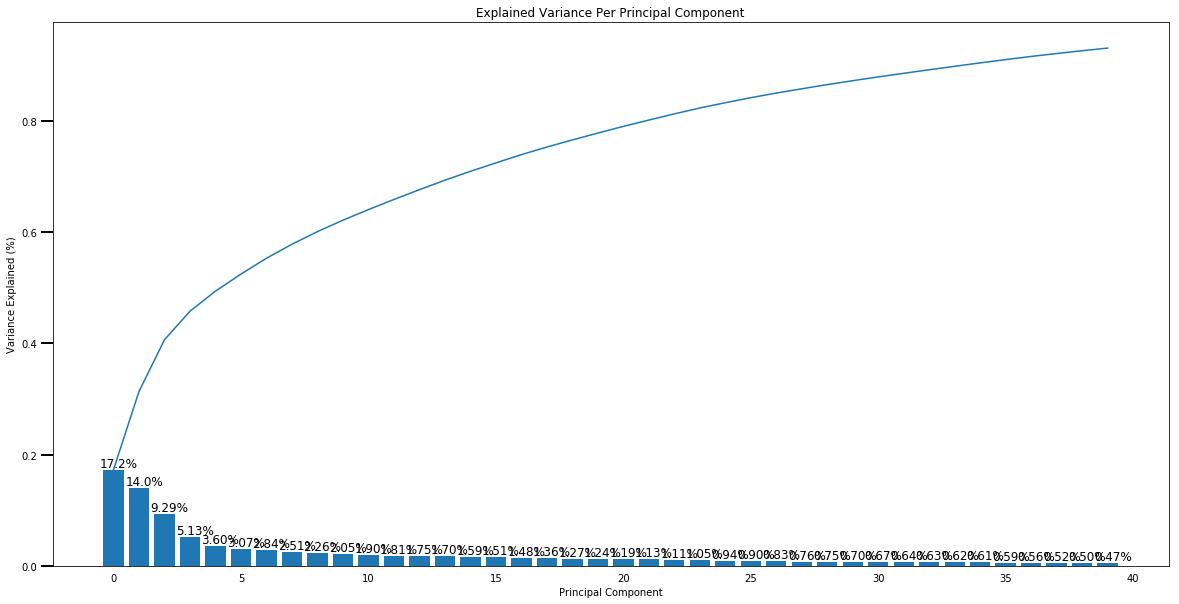

In [32]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
pca, X_pca = do_pca(40, refined_working_subset) 
scree_plot(pca)    

In [33]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, X_pca = do_pca(40, refined_working_subset) 

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

By looking at the cumulative variance graph, we found that when selecting the number of component to 40, the cumulative variance explained can reach almost 100%, thus we pickup 40 pricipal components to do the PCA

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [34]:
def getSortedABS(array):
    map_ = {}
    
    i = 0
    
    while i < array.size:
        map_[array[i]] = i
        i += 1
    
    sorted_array = sorted(array, key = abs, reverse=True)
    
    for each in sorted_array:
        feature_index = map_[each]
        print (working_subset.columns[feature_index], each)
    

In [35]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
getSortedABS(pca.components_[0])

MOBI_REGIO -0.23198750188
PLZ8_ANTG1 -0.220063674562
PLZ8_ANTG3 0.219914163579
FINANZ_MINIMALIST -0.214968502372
PLZ8_ANTG4 0.214933700384
KBA05_ANTG1 -0.213350879716
PLZ8_BAUMAX 0.210308668545
KBA05_GBZ -0.206922551658
HH_EINKOMMEN_SCORE 0.194095412501
WEALTH 0.19313270871
ORTSGR_KLS9 0.190931557059
EWDICHTE 0.189406259069
PLZ8_GBZ -0.16419850462
KONSUMNAEHE -0.163527848054
INNENSTADT -0.159783753357
FINANZ_HAUSBAUER 0.152546701788
FINANZ_SPARER 0.149844572441
PLZ8_ANTG2 0.149376588126
KBA05_ANTG4 0.149104139955
ARBEIT 0.135821607029
KBA05_ANTG3 0.130726560544
ANZ_HAUSHALTE_AKTIV 0.130604165805
RELAT_AB 0.129705904207
BALLRAUM -0.12323292351
ALTERSKATEGORIE_GROB -0.12131551465
LIFE_STAGE -0.120794170228
FINANZ_VORSORGER -0.117947018696
SEMIO_PFLICHT 0.116299039615
GEBAEUDETYP_RASTER -0.115556957889
SEMIO_REL 0.114008073892
DECADE 0.112441200864
MOVEMENT -0.103602422188
MOVEMENT -0.103602422188
SEMIO_RAT 0.0952462177079
SEMIO_TRADV 0.0903278533024
GEBURTSJAHR 0.0895873199176
FINANZ_UNA

In [48]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

getSortedABS(pca.components_[1]).head(10)

ALTERSKATEGORIE_GROB 0.244869493564
DECADE -0.243541186983
SEMIO_REL -0.23252069981
FINANZ_SPARER -0.230850017603
FINANZ_VORSORGER 0.227794424407
FINANZ_UNAUFFAELLIGER -0.223798058439
SEMIO_TRADV -0.217405097097
SEMIO_PFLICHT -0.215600965991
FINANZ_ANLEGER -0.209180732375
SEMIO_ERL 0.204788077901
GEBURTSJAHR -0.204554504977
SEMIO_KULT -0.191308481046
ALTER_HH -0.180843664681
SEMIO_LUST 0.172984268739
SEMIO_RAT -0.168163519459
RETOURTYP_BK_S 0.165305240506
ONLINE_AFFINITAET -0.163512042122
SEMIO_FAM -0.15586441141
SEMIO_MAT -0.145183802998
W_KEIT_KIND_HH 0.125158068403
FINANZ_HAUSBAUER 0.115145442755
PLZ8_ANTG3 0.100264981752
PLZ8_ANTG1 -0.0980180227916
PLZ8_ANTG4 0.0964395865266
EWDICHTE 0.0963385113011
SEMIO_KRIT 0.0958256570132
ORTSGR_KLS9 0.0949643450479
MOBI_REGIO -0.0939088573325
KBA05_GBZ -0.0913402624234
PLZ8_BAUMAX 0.0911025747231
SEMIO_KAEM 0.088810576404
WEALTH 0.0817162255988
KBA05_ANTG1 -0.0815431568722
SEMIO_SOZ -0.0806595072768
INNENSTADT -0.0786265188685
PLZ8_GBZ -0.0775

AttributeError: 'NoneType' object has no attribute 'head'

In [37]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

getSortedABS(pca.components_[2]).head(10)

ANREDE_KZ -0.372399531304
SEMIO_VERT 0.348145029091
SEMIO_KAEM -0.343395651395
SEMIO_DOM -0.315846412847
SEMIO_KRIT -0.281458745566
SEMIO_SOZ 0.270538833939
SEMIO_FAM 0.265936839173
SEMIO_KULT 0.254251561419
SEMIO_ERL -0.197079475677
SEMIO_RAT -0.194420198806
FINANZ_ANLEGER -0.169797590139
FINANZ_MINIMALIST 0.148899166369
SEMIO_REL 0.0967403161749
RETOURTYP_BK_S 0.0934670995419
DECADE -0.0901331774962
FINANZ_SPARER -0.0840775543435
W_KEIT_KIND_HH 0.0814634538765
FINANZ_VORSORGER 0.0787466358983
FINANZ_UNAUFFAELLIGER -0.0775589578547
SEMIO_MAT 0.0726352166053
GEBURTSJAHR -0.0715068334801
ALTER_HH -0.0661536087115
FINANZ_HAUSBAUER -0.0536066843465
SEMIO_PFLICHT -0.0530372718684
SEMIO_TRADV -0.0519101846246
ALTERSKATEGORIE_GROB 0.0498866340328
GREEN_AVANTGARDE 0.0495314849217
MOVEMENT 0.0495314849217
SEMIO_LUST 0.0438990090429
PLZ8_BAUMAX 0.0409369058149
ONLINE_AFFINITAET -0.0388527298255
PLZ8_ANTG1 -0.0385619640549
PLZ8_ANTG4 0.0385373204795
ORTSGR_KLS9 0.0384819963844
EWDICHTE 0.0379231

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

*answer*: From the result we can get that each principal components has some correlations with some of the features which may have weight of more than 20%. However, not all features have correlation with all of the pricipal components, for instance SEMIO_VERT have high correlation with #3 principal component while have almost no correlation with #2 principal component.

Detailed Top Features for each component:

Component #1:

    MOBI_REGIO -0.231987501628
    PLZ8_ANTG1 -0.220063674687
    PLZ8_ANTG3 0.219914162942
    FINANZ_MINIMALIST -0.214968502498
    PLZ8_ANTG4 0.214933701226
    KBA05_ANTG1 -0.213350880044
    PLZ8_BAUMAX 0.21030866816
    KBA05_GBZ -0.206922551415

Component #2:

    ALTERSKATEGORIE_GROB 0.24486949344
    DECADE -0.243541187441
    SEMIO_REL -0.232520700912
    FINANZ_SPARER -0.230850017373

Component #3:

    ANREDE_KZ -0.372399522283
    SEMIO_VERT 0.348145041358
    SEMIO_KAEM -0.343395636714
    SEMIO_DOM -0.315846416133

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [38]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cross_validation import train_test_split
# Over a number of different cluster counts...

cluster_counts = range(1,34,6)

scores = []
X_train, X_test = train_test_split(X_pca, test_size=0.9, random_state=1)

for count in cluster_counts:
    # run k-means clustering on the data and...
    print("current working on: " + str(count))
    model = KMeans(count)
    model.fit(X_train)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(X_train))
    
    scores.append(score)
    

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


current working on: 1
current working on: 7
current working on: 13
current working on: 19
current working on: 25
current working on: 31


In [39]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(cluster_counts, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');   

In [40]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
count = 15
model = KMeans(count)

cluster_all = model.fit_predict(X_pca)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

*answer*: From the curve above we can tell that the ave-distance converge between 10  to 15, so to make it simple and having less cendroid, we pick n_cluster=15 to train our model.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [41]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=';')

In [42]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

subset_below_c, working_subset_c = clean_data(customers)
processMissingValues(working_subset_c)
working_subset_c = scaler.transform(working_subset_c)
working_subset_c = pca.transform(working_subset_c)
cluster_customer = model.predict(working_subset_c)

GFK_URLAUBERTYP is invalid
GREEN_AVANTGARDE is invalid
ANZ_PERSONEN is invalid
ANZ_TITEL is invalid
ANZ_HH_TITEL is invalid
KONSUMNAEHE is invalid
GEBAEUDETYP_RASTER is invalid
MOBI_REGIO is invalid
ONLINE_AFFINITAET is invalid
KBA13_ANZAHL_PKW is invalid


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


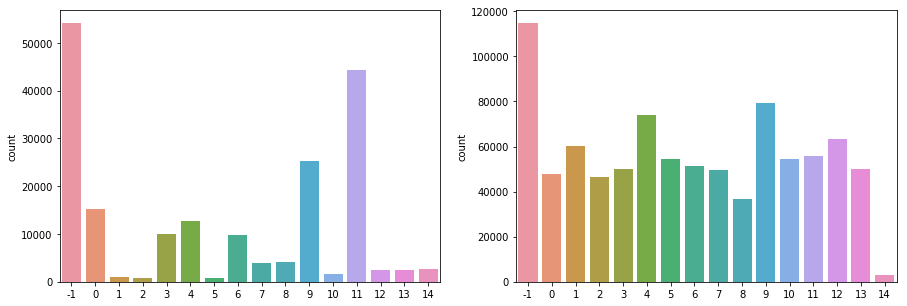

In [43]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig, ax = plt.subplots(figsize=(15,5),nrows=1, ncols=2)
customer_list = [-1] *  subset_below_c.shape[0]
customer_list.extend(cluster_customer.tolist())

all_list = [-1] * subset_below.shape[0]
all_list.extend(cluster_all.tolist())

sns.countplot(customer_list, ax=ax[0])
sns.countplot(all_list, ax=ax[1] )
fig.show()

total_customer = subset_below_c.shape[0] + working_subset_c.shape[0]
total_all = subset_below.shape[0] + X_pca.shape[0]

ratio_customer = [subset_below_c.shape[0]/total_customer]
ratio_all = [subset_below.shape[0]/total_all]

# show ratio
ratio_customer.extend([working_subset_c[np.where(cluster_customer == i )].shape[0]/total_customer for i in range(model.n_clusters)])
ratio_all.extend([X_pca[np.where(cluster_all == i )].shape[0]/total_all for i in range(model.n_clusters)])

In [44]:
ratio_all

[0.12881092344098713,
 0.05342894747767389,
 0.06770711192846668,
 0.05225078852495621,
 0.05612973661976098,
 0.08297156373110598,
 0.06102975580692107,
 0.05752781857698595,
 0.05580321828143637,
 0.04117048408868283,
 0.08899251700756602,
 0.06104883076139364,
 0.062405396641237135,
 0.07111479644218438,
 0.056057925026452474,
 0.003550185644189264]

In [45]:
f, axes = plt.subplots(2, 1)
axes[0].bar(np.arange(-1, 15), ratio_all,)
axes[0].set_ylabel('y1')
axes[0].set_ylim(top=0.4)

axes[1].bar(np.arange(-1, 15), ratio_customer,)
axes[1].set_ylabel('y2')
axes[1].set_ylim(top=0.4)
f.set_size_inches(10,10)

In [49]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

'''group 11, 9'''
group_num=11

points = working_subset_c[np.where(cluster_customer == group_num )]



print(scaler.inverse_transform(pca.inverse_transform(points))[0])
print(working_subset.columns)

print(scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[group_num])))
print(working_subset.columns)

[  4.16952532e+00   9.29382842e-01   5.23481254e+00   1.11601939e+00
   5.18817072e+00   1.21355290e+00   1.83628123e+00   2.06998025e+00
   1.94808238e+03   1.00245701e+00   1.06169516e+00   4.95212173e+00
   5.97091082e+00   4.45805950e+00   3.05028719e+00   5.78640972e+00
   6.74488540e+00   6.59503220e+00   4.05380394e+00   3.81689387e+00
   1.45183671e+00   3.15964153e+00   7.04709160e-01   9.31008520e-01
   1.94693597e+00   1.02647221e+00  -3.88623057e-05   1.00088736e+00
   9.67474782e+00   2.09891844e+00  -3.90368482e-04   1.27448070e+00
   6.15119557e+00   8.97954920e+00   6.16603605e-01   6.16974901e-03
   5.00411789e+00   1.99208209e+03   1.00000000e+00   2.25148562e+00
   2.03683981e+00   2.13939023e-02  -1.72165318e-03   3.82565194e+00
   3.22744980e+00   2.32588176e+00   4.13411573e+00   3.97173973e+00
   6.44104436e-01   4.04997322e+00   2.99280226e+00   1.34035717e+00
   1.28474638e+03   2.84905750e+00   2.97101092e+00   9.91479629e-01
   9.98907511e-02   7.89052157e-01

In [51]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

'''group 1,2,5,7,10,12,13'''

group_num=1

points = working_subset_c[np.where(cluster_customer == group_num )]


print(scaler.inverse_transform(pca.inverse_transform(points))[0])
print(working_subset.columns)

print(scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[group_num])))
print(working_subset.columns)

[  1.90219826e+00   1.08327015e+00   2.54809946e+00   3.84475380e+00
   2.46252316e+00   2.54335026e+00   3.82546983e+00   2.94203500e+00
   1.95280871e+03  -1.55219846e-02   1.07254424e+00   3.03293223e+00
   7.08667761e+00   6.95163166e+00   7.21981102e+00   3.10945414e+00
   5.75131394e+00   5.60688750e+00   3.34674641e+00   6.92813556e+00
   4.51818026e+00   1.83814131e+00   2.16873405e+00   3.35401623e+00
   6.95417348e+00   5.07948014e+00   2.85732276e-05   1.98252415e+00
   1.72260425e+01   9.35516512e-01   8.92177632e-05   4.89820098e+00
   5.01933556e+00   8.98850477e+00   1.72848756e+01  -1.31527983e-03
   9.69171898e-01   1.99181140e+03   1.00000000e+00  -3.28282084e-01
   5.54169947e-03   1.99079213e+00   1.01665464e+00   1.12304718e+00
   1.06661358e+00   6.20775374e+00   3.02968995e+00   1.97840549e+00
   3.00556349e+00   8.83399248e-01   5.10736696e+00   5.76874821e+00
   1.49127495e+02   9.67586739e-01   3.03444041e+00   2.86567981e+00
   2.10322680e+00   4.94966194e+00

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

*Answer*: By analyzing the item count / ratios of each cluster we found that 3 clusters [11, 9] overpresented, while 6 clusters [1,2,5,7,10,12,13] underpresented.

So to take a look at the centroid after the inverse transform, we could see what kind of person that belongs to those clusters. 

Take cluster 11 as example, this people are overpresented thus should be relatively popular with the mail-order company. By looking at the cendroid, we could know that those people normally more than 46 years old, likely more than 60, high FINANZ_SPARER, etc.

As for population which unpopular with the company, take cluster 1 as an example, they are male, low in FINANZ_SPARER, arround 30-45 years old, etc..

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.